In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Computing co-occurrence statistics of features in fc7 layer (before relu) of AlexNet from COCO

## Datasets used
* The training split of Tiny-Imagenet dataset was used for getting ditributions of each feature. It consists of 100,000 images of size 64x64 from 200-classes (500 images per class). 
* The training split of the COCO dataset consisting of about approximately 118,000 images was used for generating co-occurrence statistics.

## Methodology

* Images described above from Tiny-Imagenet dataset (rescaled to 224x224) were run through AlexNet to get distributions of the 4096 features present in the fc7 layer and compute the 90th percentile threshold for each feature.

* Images from COCO (rescaled to 224x224) were then run through Alexnet to obtain activations all features for all Images in COCO. 

* Using the 90th Percentile thresholds from running ImageNet through AlexNet, for each image in COCO, we obtain a 4096 dimensional one-hot vector where a feature is 1 is the activation of that feature >= the 90-percentile threshold (i.e. it occurs or is present) and 0 if the activation is < 90-percentile threshold for that feature (i.e. not present).

* The one-hot vectors for all images are then used to compute the frequency vector, co-occurrence and conditional probability matrices

The cells below load the relevant data files, then compute the 4096 dimensional on-hot vectors for each image in COCO, and finally compute and plot the co-occurrence and conditional probability matrices for all 4096 features.

In [2]:
# load the coco activations obtained from running AlexNet on COCO
coco_activations = np.load('../alexnet_imagenet_distribution/coco_output.npy')
coco_activations = coco_activations[0:1000,:]


# load 90th percentile thresholds obatined from running AlexNet on ImageNet
imagenet_percentile_threshold = np.load('../alexnet_imagenet_distribution/percentiles.npy')


In [3]:
# get features in each image in COCO which activate (have values which go above 90-percentileImageNet threshold)
activated_features_all_images_coco = coco_activations >= imagenet_percentile_threshold

# get indices of activated features
cooccurrence_indices = np.argwhere(activated_features_all_images_coco == True)


In [4]:
# create dictionary which stores activated features with index of image as key
dict_activated_features_per_image = defaultdict(list)

# get list of activated features per image
for item in cooccurrence_indices:
        dict_activated_features_per_image[item[0]].append(item[1])

In [5]:
# get the co-occurrence and occurrence statistics using list of activated features per COCO image
count = 1

co_occurrence_matrix = np.zeros((4096,4096))
occurrence_vector = np.ones(4096)

for key in dict_activated_features_per_image:
    # get the co-occurrence matrix
    activated_features = dict_activated_features_per_image[key]
    for item_1 in activated_features:
        occurrence_vector[item_1] += 1
        for item_2 in activated_features:
            if item_1 != item_2:
                co_occurrence_matrix[item_1,item_2] += 1
    count += 1

In [6]:
occurrence_vector += 1
conditional_probability_matrix = co_occurrence_matrix / occurrence_vector

# Plot frequency, co-occurence and conditional probability plots for all 4096 features from fc7 layer

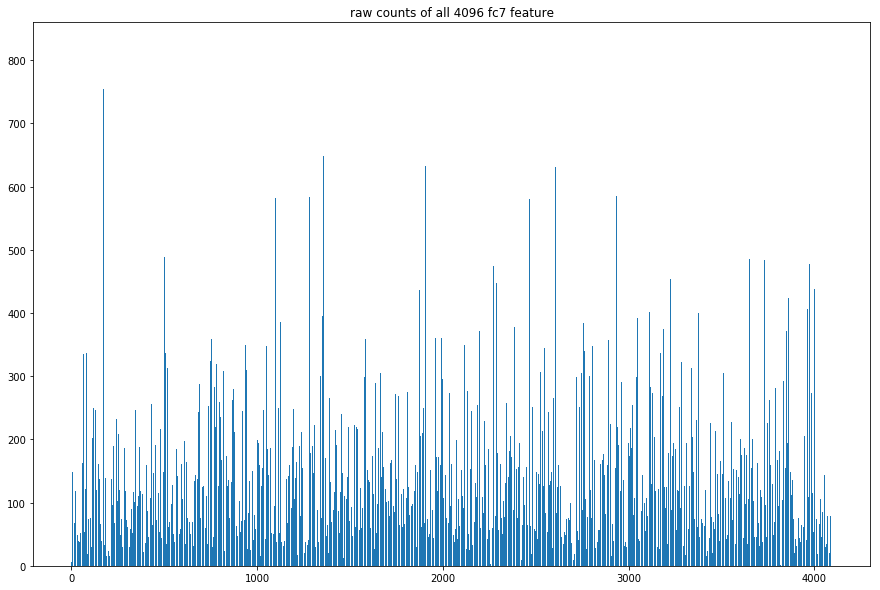

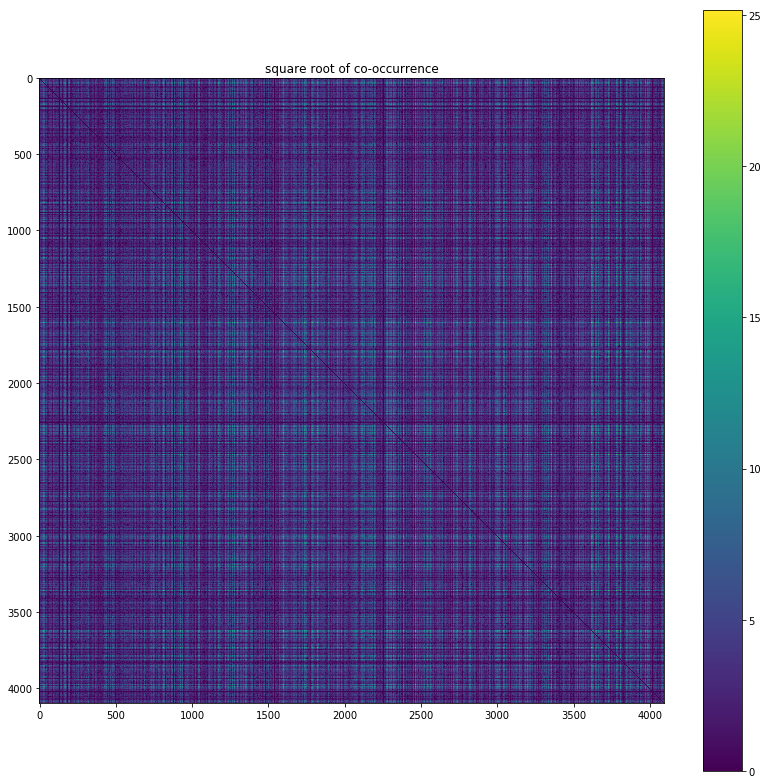

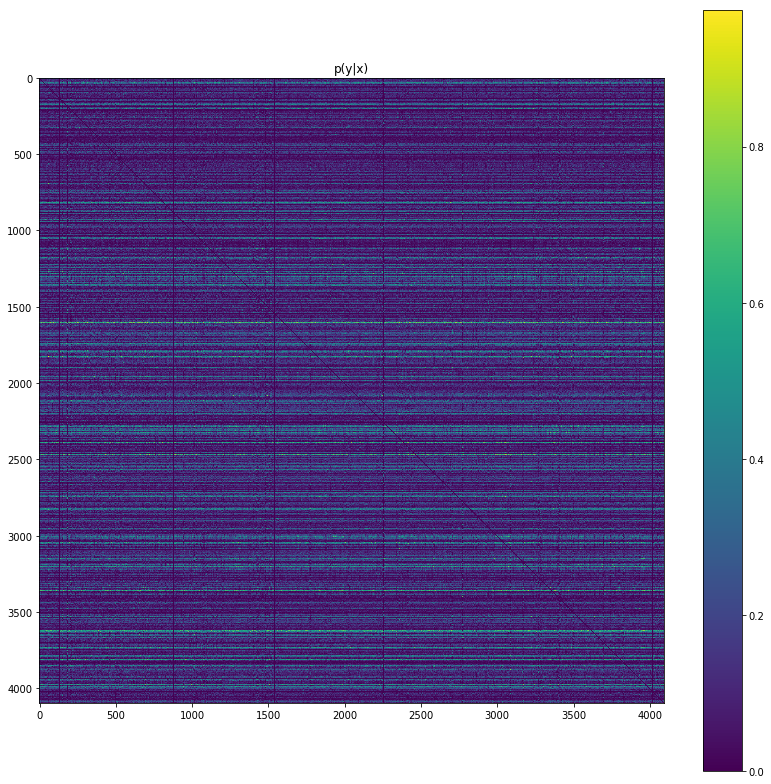

In [7]:
# compute square root of co-occurrence matrix
co_occurrence_sqrt_matrix = np.sqrt(co_occurrence_matrix)

num_classes = 4096

plt.figure(figsize=(15,10))
plt.bar(np.arange(4096), occurrence_vector)
plt.title('raw counts of all 4096 fc7 feature')
plt.savefig('frequency-plot.png')
plt.show()

# plot sqrt of co-occurrence matrix
plt.figure(figsize=(14,14))
plt.imshow(co_occurrence_sqrt_matrix, cmap='viridis', interpolation='nearest')
plt.title('square root of co-occurrence')
plt.colorbar()
plt.savefig('co-occurence-sqrt-plot.png')
plt.show()


# plot conditional probability matrix
plt.figure(figsize=(14,14))
plt.imshow(conditional_probability_matrix, cmap='viridis', interpolation='nearest')
plt.title('p(y|x)')
plt.colorbar()
plt.savefig('conditional-probability-plot.png')
plt.show()

# Visualizing bottom-10 features with lowest counts

Since it is not possible to visualize all 4096 features conveniently, I have considered the **bottom-10 features** that get activated **least frequently** among the images in COCO and **top-20 images** with **the highest activations** for each of those features.

In [8]:
#Arrange the features in ascending order and display the ones with 10 least frequent counts
sorted_indices = np.argsort(occurrence_vector)

sorted_indiced_values = np.sort(occurrence_vector)

print 'The 10 least frequent features from the fc7 layer are:'
print sorted_indices[0:10]

The 10 least frequent features from the fc7 layer are:
[1349  803 2163 3100  134  365 2111 1276 4020 2296]


images that most activate feature 1349  are:


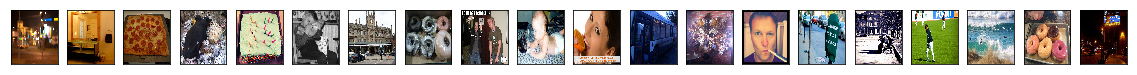

images that most activate feature 803  are:


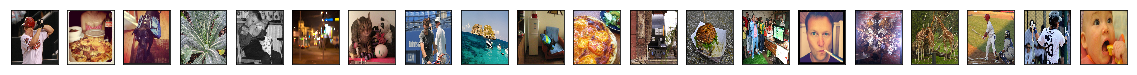

images that most activate feature 2163  are:


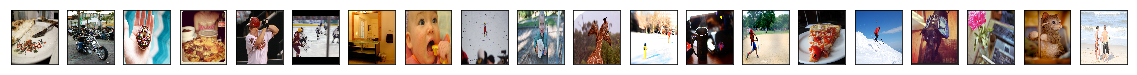

images that most activate feature 3100  are:


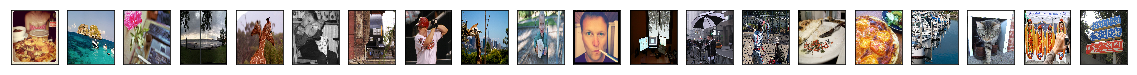

images that most activate feature 134  are:


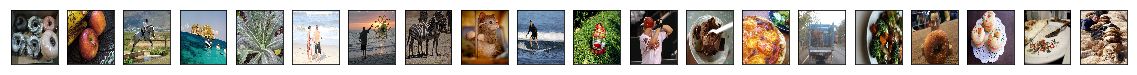

images that most activate feature 365  are:


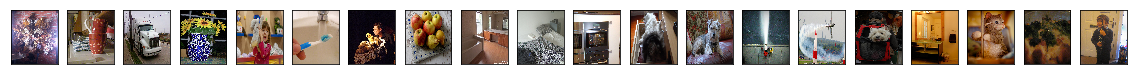

images that most activate feature 2111  are:


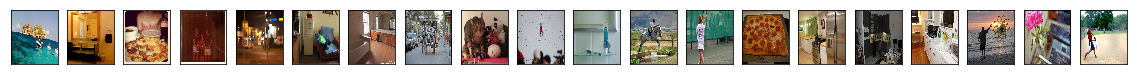

images that most activate feature 1276  are:


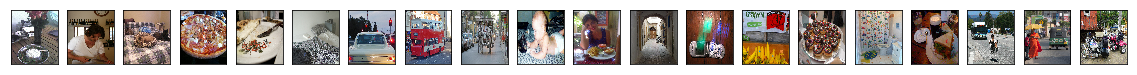

images that most activate feature 4020  are:


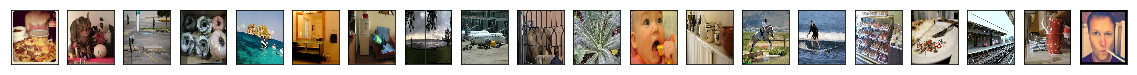

images that most activate feature 2296  are:


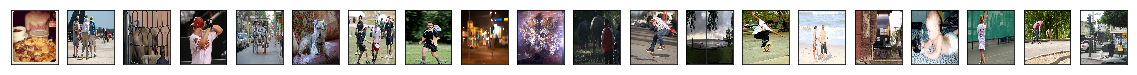

In [9]:
image_list = np.load('../alexnet_imagenet_distribution/image_list_coco.npy')
for index in sorted_indices[0:10]:
    feature = coco_activations[:,index]
    print 'images that most activate feature',index,' are:'
    sorted_activations_current_feature = np.argsort(feature)
    sorted_activations_current_feature = np.flipud(sorted_activations_current_feature) 
    sorted_images_current_feature = image_list[sorted_activations_current_feature[0:20]]
    fig = plt.figure(figsize=(20,1))
    for image_index,image in enumerate(sorted_images_current_feature):
        img=mpimg.imread('../data/train2017/'+image)
        ax = fig.add_subplot(1, 20, image_index+1)
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        time.sleep(1)
    plt.show()

# Visualizing top-10 features with highest counts

I have considered the **top-10 features** that get activated **most frequently** among the images in COCO and **top-20 images** with **the highest activations** for each of those features.

In [10]:
#Arrange the features in descending order and display the ones with 10 most frequent counts
sorted_indices = np.argsort(occurrence_vector)
sorted_indices = np.flipud(sorted_indices)


print 'The 10 most frequent features from the fc7 layer are:'
print sorted_indices[0:10]

The 10 most frequent features from the fc7 layer are:
[2018  174  840 3254 1629 1201  996 1855 1358 1602]


images that most activate feature 2018  are:


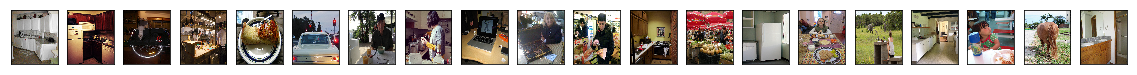

images that most activate feature 174  are:


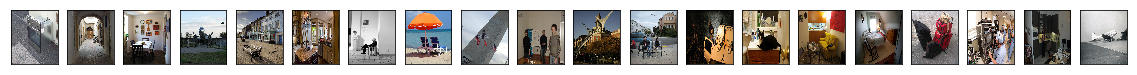

images that most activate feature 840  are:


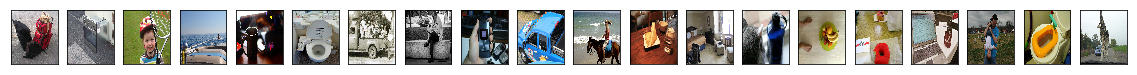

images that most activate feature 3254  are:


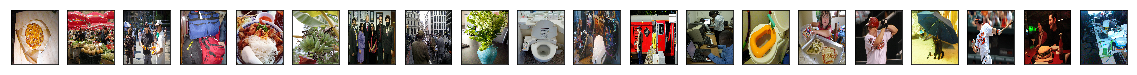

images that most activate feature 1629  are:


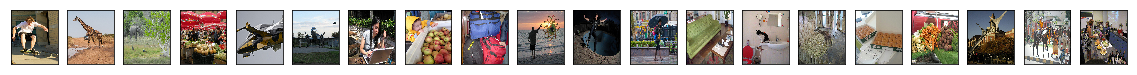

images that most activate feature 1201  are:


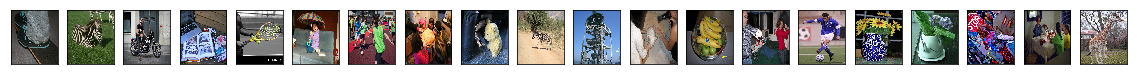

images that most activate feature 996  are:


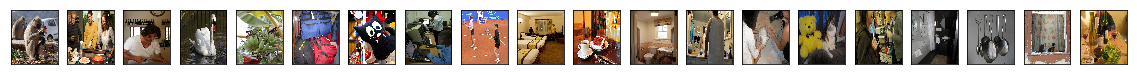

images that most activate feature 1855  are:


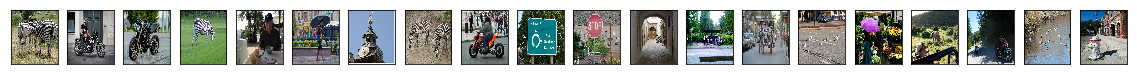

images that most activate feature 1358  are:


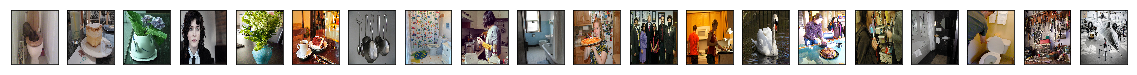

images that most activate feature 1602  are:


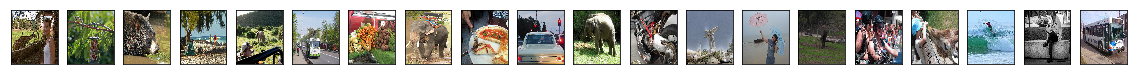

In [11]:
image_list = np.load('../alexnet_imagenet_distribution/image_list_coco.npy')
for index in sorted_indices[0:10]:
    feature = coco_activations[:,index]
    print 'images that most activate feature',index,' are:'
    sorted_activations_current_feature = np.argsort(feature)
    sorted_activations_current_feature = np.flipud(sorted_activations_current_feature) 
    sorted_images_current_feature = image_list[sorted_activations_current_feature[0:20]]
    fig = plt.figure(figsize=(20,1))
    for image_index,image in enumerate(sorted_images_current_feature):
        img=mpimg.imread('../data/train2017/'+image)
        ax = fig.add_subplot(1, 20, image_index+1)
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        time.sleep(1)
    plt.show()